In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from lenet5_torch import LeNet5
from torch_dataset import TorchDataset
import pandas as pd
import numpy as np
import os
import time
from matplotlib import pyplot as plt
from tqdm import tqdm

In [2]:
torch.cuda.is_available()

True

In [3]:
torch.cuda.device_count()

1

In [4]:
def draw_plot(name, fig_li):
    #fig = plt.figure(1)	#identifies the figure 
    plt.plot([i for i in range(len(fig_li))], fig_li)
    plt.xlabel("epoch",fontsize='13')
    plt.ylabel(name,fontsize='13')
    plt.grid()
    plt.savefig(f'{name}.png')
    #plt.clf()



In [5]:
pre_path = "../image/"
train = 'train.txt'
val = 'val.txt'
test = 'test.txt'

train_data = TorchDataset(filename=os.path.join(pre_path, train), image_dir=pre_path,repeat=1)
val_data = TorchDataset(filename=os.path.join(pre_path, val), image_dir=pre_path,repeat=1)
test_data = TorchDataset(filename=os.path.join(pre_path, test), image_dir=pre_path,repeat=1)


In [6]:
def encode_label(y):
        enc_y = np.zeros((y.shape[0],50))
        for idx,label in enumerate(y):
            enc_y[idx,label] = 1
        return torch.from_numpy(enc_y)

def evaluate(Y_pred, Y_True):
        # Top-1
        pred_label = np.argmax(Y_pred, axis=1)
        top1 = round(sum(Y_True == pred_label)/(1.0*len(Y_True)), 4)

        # Top-5
        size = Y_True.shape[0]
        count = 0
        for i in range(size):
            top5 = np.argpartition(Y_pred[i],-5)[-5:]
            if Y_True[i] in top5:
                count += 1
        top5 = round(count/size,4)

        return top1,top5

In [7]:
def train(train_data):
    model.train()
    train_loader = DataLoader(dataset=train_data, batch_size=256, shuffle=False)

    for train_x, train_y in  tqdm(train_loader):

        optimizer.zero_grad()
        
        N,H,W = train_x.shape
        train_x = train_x.reshape(N,1,H,W)
        train_y = encode_label(train_y)
        train_x = train_x.to(device)
        train_y = train_y.to(device)
        
        predict_y = model(train_x.float())
        
        loss = criterion(train_y.float(), predict_y)
        loss.backward()
        
        optimizer.step()
        
    return loss.item()

def test(test_data_):
    model.eval()
    test_data_ = DataLoader(dataset=test_data_, batch_size=450, shuffle=False)

    for idx, (test_x, test_y) in enumerate(test_data_):
            N,H,W = test_x.shape
            test_x = test_x.reshape(N,1,H,W)
            
            test_x = test_x.to(device)
            test_y = test_y.to(device)
        
            predict_y = model(test_x.float()).cpu()
            predict_y = predict_y.detach().numpy()
            test_y = test_y.cpu()
            test_y = test_y.detach().numpy().reshape(-1)
            
            top1,top5 = evaluate(predict_y, test_y)

    return top1,top5


In [12]:
epoch = 1
batch = 200
model = LeNet5()
optimizer = torch.optim.Adam(params=model.parameters(), lr=0.0001)
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.cuda()

In [13]:
best_val = best_test = 0
best_val_epoch = best_test_epoch = 0
loss_list = []
train_list = []
val_list = []
test_list = []
start = time.time()
for epoch in range(1):
    loss = train(train_data)
    loss_list.append(loss)
    
    top1_val, top5_val = test(val_data)
    val_list.append(top5_val)
    top1_test, top5_test = test(test_data)
    test_list.append(top5_test)
    if top1_val > best_val:
        best_val = top1_val
        best_val_epoch = epoch
        best_model = model
    if top1_test > best_test:
        best_test = top1_test
        best_test_epoch = epoch
        best_test_model = model
    
    print(loss)
    print(time.time()-start)
end = time.time()
print(end-start)


100%|██████████| 248/248 [01:48<00:00,  2.29it/s]


-588.6942138671875
109.79986929893494
109.80010962486267


In [14]:
top1_val, top5_val = test(val_data)
top1_val, top5_val

(0.02, 0.1)

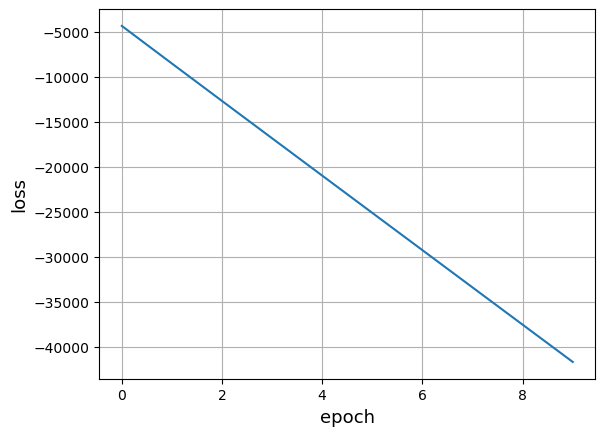

In [10]:
draw_plot("loss", loss_list)

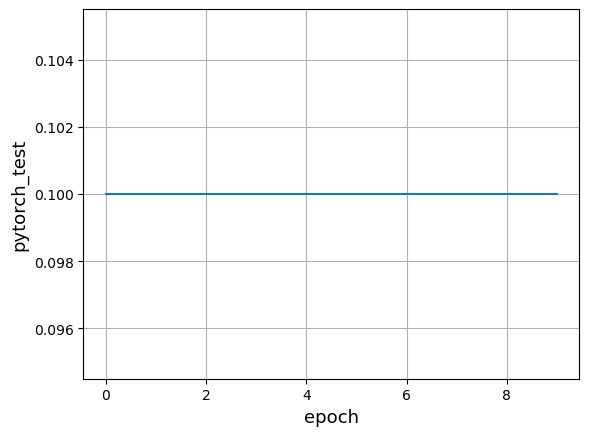

In [11]:
draw_plot("pytorch_test", test_list)

# try

In [ ]:
from torchvision.datasets import mnist
from torchvision.transforms import ToTensor

train_dataset = mnist.MNIST(root='./train', train=True, transform=ToTensor(),download=True)
train_dataset

In [ ]:
from torch.utils.data import DataLoader
train_loader = DataLoader(train_dataset, batch_size=256)

In [ ]:
for idx, (train_x, train_label) in enumerate(train_loader):
    print(train_x.shape)

In [ ]:
val_x, val_y = val_data.__getitem__()